# Social Representations and Boundaries of Humor: A focus on Gender roles

## Research questions: 

1) How are men and women depicted in New Yorker cartoons and captions, and do these depictions reflect traditional gender roles or stereotypes?

2) How does audience response (e.g., votes or winning captions) relate to gendered content—do captions about one gender receive more positive attention ?

## Structure:

### 0. Method to detect gender

Detect gendered references in captions/descriptions and assign a gender to each of them (male, female, both, neutral). 

*Method*: Found two gender lists that contains gendered word. I wanted a longer list so I manually augmented it with universal gendered word and contextual gender markers. Then I added words based on what words are actually on the dataset.

### 1. General distributions

1) Overall presence of gender in captions and image descriptions (barplot)

2) Plot to see overall evolution over time

### 2. How are men/women depicted in the captions

1) Find the top words associated with each gender (wordclouds)

2) Find topic related to man and woman (topic detection)

### 3. Audience response to gender related captions ?

1. Are captions mentionning gender more funny ? (funnyness score + t-test: $H_0$: There are no difference in funiness between gendered caption and non gendered captions. If refuted: $H_0$: There are no difference in funiness between male gendered caption and female gendered caption. *hope it's refuted*)

2. Does it change over time ?

## Initialisation of the root path

In [132]:
%matplotlib inline

In [133]:
from pathlib import Path
import sys

def warning1(text): print("WARNING!!! ", text)
ACTIVATE_PRINTS = False

# Get correct root path
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if all((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

if ACTIVATE_PRINTS: print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print(root)

d:\GitHub\ada-2025-project-adacore42


## Imports

In [134]:
# working librairies
import os
import pickle
import csv

sys.path.append(os.path.abspath(".."))

# utils
from src.utils.general_utils import *

# class with functions
from src.models.gender_analysis import GenderAnalysis

# basics
import pandas as pd
import numpy as np

# other
from collections import Counter

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
import plotly.express as px

# text processing libraries
import nltk
import spacy
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Statistical testing
from scipy.stats import mannwhitneyu

In [135]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(DATA_PREPARATION_PY_PATH.resolve()) #If works: ...../ADAcore42/src/data/DataPreparation.py

D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\src\data\DataPreparation.py


In [5]:
# %run {DATA_PREPARATION_PY_PATH.resolve()}

## Loading the data



In [6]:
ga = GenderAnalysis()

In [7]:
root / STORED_DATAPREP_PKL_PATH

WindowsPath('d:/GitHub/ada-2025-project-adacore42/data/data_prepared.pkl')

In [8]:
data = ga.load_pickle(root / STORED_DATAPREP_PKL_PATH)

In [9]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [10]:
dataA_removed, dataC_removed = drop_NaN(dataA, dataC)

In [11]:
print(f"Length dataA: {len(dataA_removed)}\nShape dataC: {dataC_removed.shape}")

Length dataA: 240
Shape dataC: (240, 8)


In [12]:
dataA_removed[0].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score_scaled,funny_group
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,44.774194,funny
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,39.317972,funny
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,38.304147,funny
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,36.387097,funny
4,"If you can meditate here, you can meditate any...",1.617647,0.126764,34,18,11,5,35.539171,funny


In [13]:
dataC_removed.head()

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,date
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],NaT
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,NaT
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",2016-03-21
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,2016-03-27
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],2016-04-03


## Step 0: Augment the gendered lists

Include male and female names: asked to chatGPT to produce me a list (based on Social Security Administration data)

Include public figures: asked chatGPT for 50 male and female celebrities

The list can be found in gender_analysis.py

## Step 1: Detect gender

Use gender lexicons, but we need to define them first. 

For P2, I used two small lists with common gendered terms. For P3 I want to extend them based on what what terms are used in the contest!

### In the image description

In [13]:
# detect gender in the cartoon descriptions
dataC0 = dataC_removed.copy(deep=True)
dataC1 = ga.get_metadata(dataC0)

In [14]:
## How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts_plotly(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons", 
    save = r"saved plots\counts_cartoons.html"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions_plotly(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender",
    save = r"saved plots\cumulative_cartoons.html"
)

### In the captions

In [14]:
# DON'T RUN THIS AGAIN
dataTop = ga.get_Top_captions(dataA_removed)

# Results were saved here: 
STORED_DATAPREP_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions.pkl'
with open(STORED_DATAPREP_PKL_PATH, "wb") as f:
    pickle.dump(dataTop, f)

In [ ]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [18]:
count = []

for idx, contest in enumerate(data_caption):
    # Count mentions per contest
    gender_counts = (
        contest["gender_mention"]
        .value_counts()
        #.unstack(fill_value=0)
        .reset_index()
    )
    count.append(gender_counts)

In [20]:
# How often men/women are mentionned in captions

overall_counts, pivoted = ga.distribution_captions(count)

# In the plots I don't show the neutral, because it is a huge number compared
# to the other categories

# Plot Overall counts
ga.plot_overall_counts_plotly(
    overall_counts,
    title="Overall Presence of Gender Mentions in the Captions",
    xlabel="Gender Category",
    ylabel="Number of Captions",
    neutral = True, 
    save = r"saved plots\counts_captions.html"
)

# Evolution over time
cumulative = pivoted.cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions_plotly(
    cumulative,
    title="Cumulative Gender Mentions in Captions",
    xlabel="Contest index (chronological)",
    ylabel="Number of Captions",
    legend_title="Gender",
    neutral = False, 
    save = r"saved plots\cumulative_captions.html"
)

## Step 2: How are men/women depicted in the captions ? 

### Verbs and adjectives associated with genders

**METHOD**

1) Using the men and women dictionnaries, I iterated through the contests and counted the occurence of verbs and adjectives in men and women labeled captions.
2) Created wordclouds to show the results

The commented code shows the pipeline used to associate verbs and adjectives to each gender.

In [ ]:
# nlp = spacy.load("en_core_web_sm")

# verbs_male = Counter()
# verbs_female = Counter()
# adjs_male = Counter()
# adjs_female = Counter()

# for contest in data_caption:

#     male_caps   = contest.loc[contest['gender_mention'] == 'male',   'caption'].tolist()
#     female_caps = contest.loc[contest['gender_mention'] == 'female', 'caption'].tolist()

#     # process male captions in batch
#     for doc in nlp.pipe(male_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_male[token.lemma_] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_male[token.lemma_] += 1

#     # process female captions in batch
#     for doc in nlp.pipe(female_caps):
#         for token in doc:
#             if token.pos_ == "VERB":
#                 verbs_female[token.lemma_.lower()] += 1
#             elif token.pos_ == "ADJ":
#                 adjs_female[token.lemma_.lower()] += 1

In [ ]:
# STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
# with open(STORED_FREQS_PKL_PATH, "wb") as f:
#     pickle.dump({"verbs_male": verbs_male, "verbs_female": verbs_female, "adjs_male": adjs_male, "adjs_female": adjs_female}, f)

#### Visualisation

In [5]:
ga = GenderAnalysis()

In [6]:
STORED_FREQS_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\freqs_verb_adj.pkl'
data_wordcloud = ga.load_pickle(STORED_FREQS_PKL_PATH)

verbs_male = data_wordcloud['verbs_male']
verbs_female = data_wordcloud['verbs_female']

adjs_male = data_wordcloud['adjs_male']
adjs_female = data_wordcloud['adjs_female']

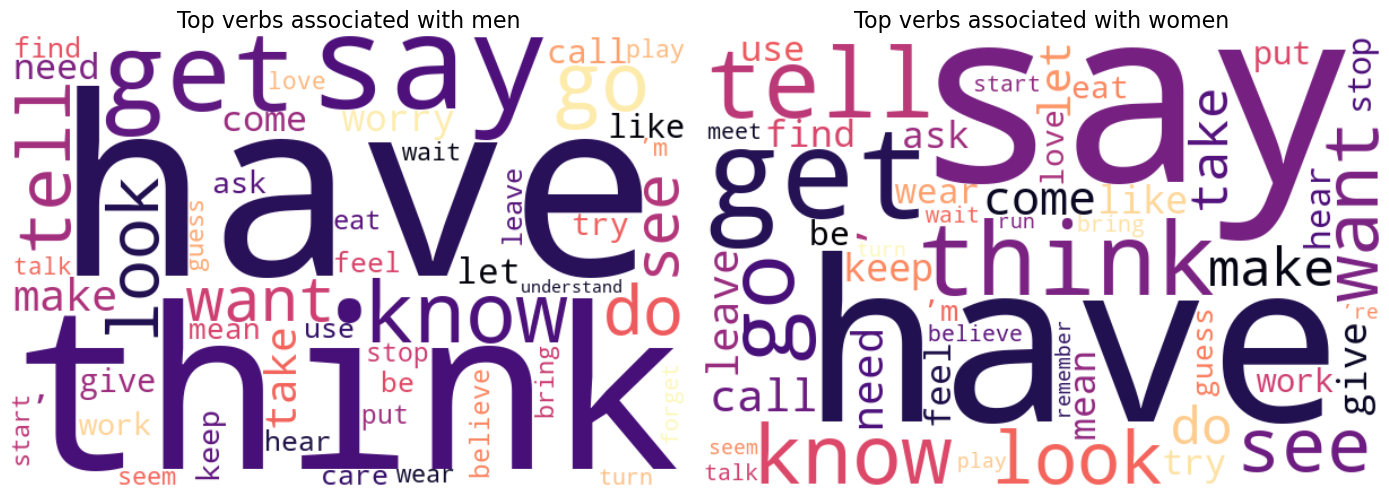

In [7]:
# --- Generate the word clouds - VERB ---
male_cloud_verb = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_male)

female_cloud_verb = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(verbs_female)

ga.plot_wordclouds(male_cloud_verb, female_cloud_verb, 'verbs')

# size indicates frequency, color is just for esthetics

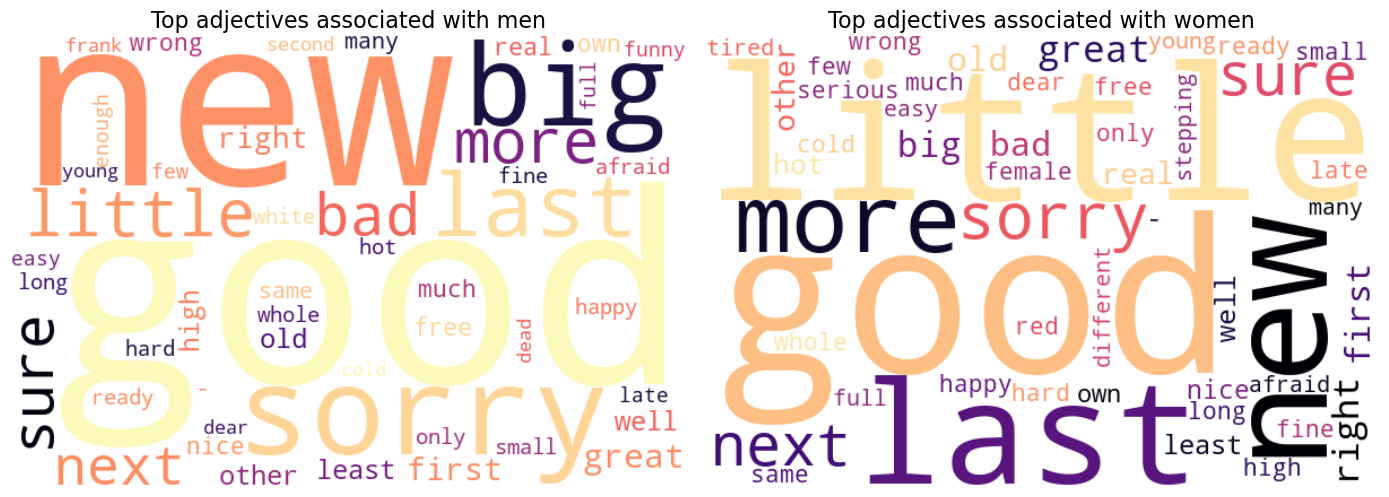

In [8]:
# --- Generate the word clouds - ADJ ---
male_cloud_adj = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_male)

female_cloud_adj = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='magma',
    max_words=50
).generate_from_frequencies(adjs_female)

ga.plot_wordclouds(male_cloud_adj, female_cloud_adj, 'adjectives')

In [9]:
# STORED_WORDCLOUD_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\wordcloud.pkl'
# with open(STORED_WORDCLOUD_PKL_PATH, "wb") as f:
#     pickle.dump({"male_adj": male_cloud_adj, "female_adj": female_cloud_adj, "male_verb": male_cloud_verb, "female_verb": female_cloud_verb}, f)

#### Comments **TO ADD**

### Topic modelling

**METHOD**

1) Run BERTopic for each gender. (Since my computer is weak and that I have over 300k captions gendered as male, I had to run BERTopic four separate times.)
2) Aggregate the topic from BERTopic to comprehensive ones. The dictionnaries of this are stored in src\models\gender_analysis.py.
3) Handle the unbalance: Since we have an umbalance in the number of captions for each gender. I decided to use the top themes that cover 60% of captions.
4) Find the top words associated with each aggregated theme
5) Interactive plot for each gender, for each topic representative words are plotted.

The following commented cells are the code I used to do some topic detection.


In [11]:
## Creating two dataframes with all the men and women labelled captions

# caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
# caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

# for idx, contest in enumerate(data_caption[1:]):
#     print(f"Contest: {idx}")
#     male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
#     frames = [caption_male_df, male_caps]
#     caption_male_df = pd.concat(frames)

#     female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
#     frames_ = [caption_female_df, female_caps]
#     caption_female_df = pd.concat(frames_)

# # Save DataFrame to CSV
# caption_female_df.to_csv('all_caption_female.csv', index=False)
# caption_male_df.to_csv('all_caption_male.csv', index=False)

In [ ]:
# ## TOPIC MODELLING: FINDING TOPICS WITH BERT AND LABELING EACH CAPTIONS WITH A TOPIC, THEN SAVING RESULTS

# # -------------------------------------
# # 1. Load captions
# # -------------------------------------
# data_m = pd.read_csv('all_caption_male.csv')
# captions = data_m['caption'].tolist()
# captions_1 = captions[:76619]
# captions_2 = captions[76619:153238]
# captions_3 = captions[153238:229857]
# captions_4 = captions[229857:]

In [13]:
# # -------------------------------------
# # 1.5 Create list of lists of caption so that BERT can handle them
# # -------------------------------------

# captions_list = [captions_1, captions_2, captions_3, captions_4]

# # -------------------------------------
# # 2 Loop to iterate over all of the captions
# # -------------------------------------
# i = 0
# for captions_ in captions_list:
#     i+=1
#     # Better than default: tuned for short sentences
#     embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

#     # Compute caption embeddings
#     embeddings = embedding_model.encode(captions_, show_progress_bar=True)

#     # -------------------------------------
#     # 3. Create BERTopic model
#     # -------------------------------------
#     topic_model = BERTopic(
#         embedding_model=embedding_model,
#         min_topic_size=75,          # 25 for female, 75 for male (male has 5 times the captions)
#         n_gram_range=(1, 2),        # allow bigrams (important for humor)
#         verbose=True
#     )

#     # Fit model using embeddings
#     topics, probs = topic_model.fit_transform(captions_, embeddings)

#     # -------------------------------------
#     # 4. Inspect topics
#     # -------------------------------------
#     # topic_model.get_topic_info().head()

#     # -------------------------------------
#     # 5. Save results 
#     # -------------------------------------
#     df_topics = pd.DataFrame({
#         "caption": captions_,
#         "topic": topics,
#     })

#     df_topic_info_male = topic_model.get_topic_info()

#     df_topics.to_csv(f"caption_{i}_labeled_topics_male.csv", index=False)
#     df_topic_info_male.to_csv(f"info_topics_male_{i}.csv", index=False)

#### Visualization

In [ ]:
# Loading all of our stored topics

# topics_female_info = pd.read_csv(r"src/data/info_topics_female.csv")
# topics_female_caption = pd.read_csv(r"src/data/caption_labeled_topics_female.csv")

# topics_male_info_1 = pd.read_csv(r"src/data/info_topics_male_1.csv")
# topics_male_info_2 = pd.read_csv(r"src/data/info_topics_male_2.csv")
# topics_male_info_3 = pd.read_csv(r"src/data/info_topics_male_3.csv")
# topics_male_info_4 = pd.read_csv(r"src/data/info_topics_male_4.csv")

# topics_male_caption_1 = pd.read_csv(r"src/data/caption_1_labeled_topics_male.csv")
# topics_male_caption_2 = pd.read_csv(r"src/data/caption_2_labeled_topics_male.csv")
# topics_male_caption_3 = pd.read_csv(r"src/data/caption_3_labeled_topics_male.csv")
# topics_male_caption_4 = pd.read_csv(r"src/data/caption_4_labeled_topics_male.csv")

# df_topics_female = ga.map_topic(topics_female_caption, ga.agg_topic_female)
# df_topics_female.to_csv("src/data/topic_female.csv")

# df_topics_1 = ga.map_topic(topics_male_caption_1, ga.agg_topic_male_1)
# df_topics_2 = ga.map_topic(topics_male_caption_2, ga.agg_topic_male_2)
# df_topics_3 = ga.map_topic(topics_male_caption_3, ga.agg_topic_male_3)
# df_topics_4 = ga.map_topic(topics_male_caption_4, ga.agg_topic_male_4)

# frames = [df_topics_1, df_topics_2, df_topics_3, df_topics_4]

# df_topics_male = pd.concat(frames)

# df_topics_male.to_csv("src/data/topic_male.csv")

In [36]:
ga = GenderAnalysis()
df_topics_female = pd.read_csv("src/data/topic_female.csv")
plot_topic_female = ga.plot_topic(df_topics_female, gender='female', theme_keywords=ga.theme_words_female, theme_colors=ga.theme_colors_female)

In [38]:
df_topics_male = pd.read_csv("src/data/topic_male.csv")
plot_topic_male = ga.plot_topic(df_topics_male, gender='male', theme_keywords=ga.theme_words_male, theme_colors=ga.theme_colors_male)

In [ ]:
# plot_topic_male.write_html("topic_male.html")
# plot_topic_female.write_html("topic_female.html")

#### Comments

The analysis of New Yorker captions reveals a stark gendered difference in humor. Women are often depicted as archetypes—mothers, brides, witches—emphasizing their roles and cultural expectations, with humor arising from what kind of woman they are rather than what they do. Men, in contrast, appear more in situational contexts—workplaces, friendships, absurd events—where humor comes from what happens to them, not their identity. This pattern shows that gender shapes not just who appears in captions, but how jokes are constructed: women as symbols, men as default actors. Despite decades of submissions, these narrative shortcuts persist, reflecting enduring patterns in gendered humor

## Step 3: How does audience response relate to gendered content ? 

Now that we saw the top words and topics associated to each gender. I think it's interesting to see if the genders are laughed at in the same way.

In [15]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [30]:
# # Creating two dataframes with all the men and women labelled captions

# caption_male_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'male'].copy(deep=True)
# caption_female_df = data_caption[0].loc[data_caption[0]['gender_mention'] == 'female'].copy(deep=True)

# for idx, contest in enumerate(data_caption[1:]):
    
#     male_caps = contest.loc[contest['gender_mention'] == 'male'].copy(deep=True)
#     frames = [caption_male_df, male_caps]
#     caption_male_df = pd.concat(frames)

#     female_caps = contest.loc[contest['gender_mention'] == 'female'].copy(deep=True)
#     frames_ = [caption_female_df, female_caps]
#     caption_female_df = pd.concat(frames_)

# # Save DataFrame to CSV
# caption_female_df.to_csv(r'src\data\all_caption_female.csv', index=False)
# caption_male_df.to_csv(r'src\data\all_caption_male.csv', index=False)

### Evolution of the funny score over contest and distribution

In [20]:
# mean + std score over contest
mean_funny_female = []
std_funny_female = []
list_funny_female = []

for contest in data_caption:
    fem = contest[contest['gender_mention'] == 'female']
    mean_funny_female.append(fem['funny_score_scaled'].mean())
    std_funny_female.append(fem['funny_score_scaled'].std())
    list_funny_female.append(fem['funny_score_scaled'].values)

In [22]:
mean_funny_male = []
std_funny_male = []
list_funny_male = []

for contest in data_caption:
    male = contest[contest['gender_mention'] == 'male']
    mean_funny_male.append(male['funny_score_scaled'].mean())
    std_funny_male.append(male['funny_score_scaled'].std())
    list_funny_male.append(male['funny_score_scaled'].values)

First, we see if the mean are the same. And surprisingly, they are

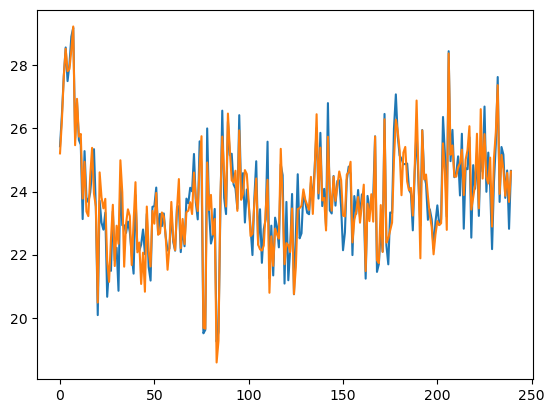

In [29]:
plt.plot(mean_funny_female)
plt.plot(mean_funny_male)
         

In [69]:
# plt.figure(figsize=(20,8))
# plt.fill_between(x=np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], y1=np.array(mean_funny_female)+np.array(std_funny_female), y2=np.array(mean_funny_female)-np.array(std_funny_female),
#                  alpha = 0.3, linestyle = '--')
# plt.plot(np.linspace(0, len(mean_funny_female), len(mean_funny_female)+1)[1:], mean_funny_female, color = 'black')
# plt.title("Funiness score for female caption over all contests")

In [70]:
# plt.figure(figsize=(20,8))
# plt.fill_between(x=np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], y1=np.array(mean_funny_male)+np.array(std_funny_male), y2=np.array(mean_funny_male)-np.array(std_funny_male),
#                  alpha = 0.3, linestyle = '--')
# plt.plot(np.linspace(0, len(mean_funny_male), len(mean_funny_male)+1)[1:], mean_funny_male, color = 'black')
# plt.title("Funiness score for male caption over all contests")

As we can see, the plots are quite similar. Let's just check the overall distribution.

In [ ]:
flatten_funny_male = ga.flatten(list_funny_male)
flatten_funny_female = ga.flatten(list_funny_female)

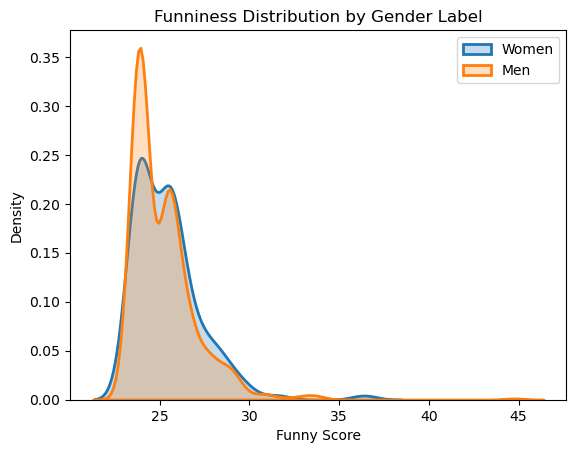

In [68]:
sns.kdeplot(flatten_funny_female[0], fill=True, label = 'Women', linewidth=2)
sns.kdeplot(flatten_funny_male[0], fill=True, label="Men", linewidth=2)

plt.title("Funniness Distribution by Gender Label")
plt.xlabel("Funny Score")
plt.legend()
plt.show()

The distribution of the funny score is quite similar. Let's do some statistical testing just to be sure.

In [126]:
def cliffs_delta(x, y):
    """
    Compute Cliff's delta effect size.
    Returns value in [-1, 1].
    """
    x = np.asarray(x)
    y = np.asarray(y)

    n_x = len(x)
    n_y = len(y)

    greater = 0
    lower = 0

    for xi in x:
        greater += np.sum(xi > y)
        lower += np.sum(xi < y)

    return (greater - lower) / (n_x * n_y)


In [ ]:
### H0: There are no difference in scores between men and women ?

u_stat, p_value = mannwhitneyu(flatten_funny_female[0], flatten_funny_male[0], alternative="two-sided")
print("Mann-Whitney U:", u_stat)
print("p-value:", p_value)

Mann-Whitney U: 39666.5
p-value: 0.09654745396792908


### Best and Worst funny caption per gender

The idea here is to compare if there is a difference in score when it's really funny and when it's not at all. Let's look at the top and worst 5% for each gender.

Here is the method: 

- We focused on captions explicitly labeled as male or female using gendered words.
- For each gender, we identified the top and bottom or 5% of captions based on their funniness score.
- This allows us to study extreme audience reactions rather than average behavior.
- Since funniness scores are skewed and non-normally distributed, we used the Mann–Whitney U test, a non-parametric alternative to the t-test.
- We tested two hypotheses separately:
- Whether the best captions differ by gender
- Whether the worst captions differ by gender
- To complement statistical significance, we computed Cliff’s delta as an effect size measure.
- This ensures that we distinguish between statistical significance and practical relevance.

In [136]:
def split_top_bottom(df, score_col="funny_score_scaled", q=0.10):
    """
    Splits a dataframe into top and bottom q percent based on a score column.
    """
    lower_thresh = df[score_col].quantile(q)
    upper_thresh = df[score_col].quantile(1 - q)

    bottom = df[df[score_col] <= lower_thresh].copy()
    top = df[df[score_col] >= upper_thresh].copy()

    return top, bottom

In [137]:
df_women = pd.read_csv(r"src\data\all_caption_female.csv")
df_men = pd.read_csv(r"src\data\all_caption_male.csv")

In [146]:
q = 0.01
men_top, men_bottom = split_top_bottom(df_men, q=q)
women_top, women_bottom = split_top_bottom(df_women, q=q)

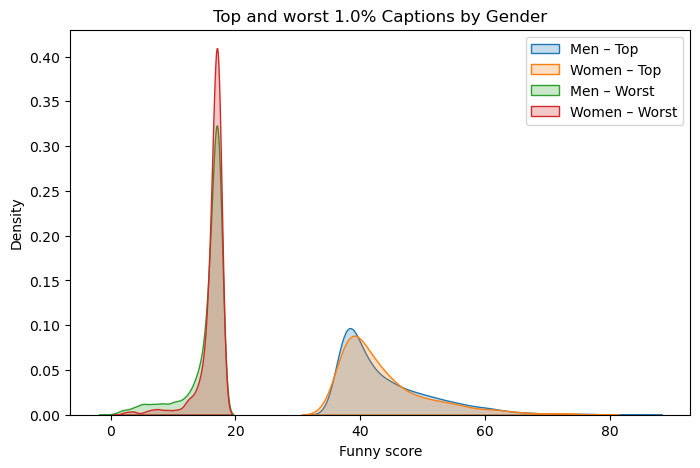

In [147]:
plt.figure(figsize=(8, 5))

sns.kdeplot(men_top["funny_score_scaled"], label="Men – Top", fill=True)
sns.kdeplot(women_top["funny_score_scaled"], label="Women – Top", fill=True)
sns.kdeplot(men_bottom["funny_score_scaled"], label="Men – Worst", fill=True)
sns.kdeplot(women_bottom["funny_score_scaled"], label="Women – Worst", fill=True)

plt.title(f"Top and worst {q*100}% Captions by Gender")
plt.xlabel("Funny score")
plt.legend()
plt.show()


Well, well, well, always the same thing. The jokes for each gender seem to be received equally. But let's do some statistical testing just to be sure. 

Worst captions

H₀: The distribution of worst funny scores is the same for men and women.

Best captions

H₀: The distribution of best funny scores is the same for men and women.


Mann–Whitney answers:

If I randomly pick one caption from men and one from women, is one more likely to have a higher funny score?

In [144]:
# worst 5% funny scores
men_worst = men_bottom["funny_score_scaled"]
women_worst = women_bottom["funny_score_scaled"]

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(
    men_worst,
    women_worst,
    alternative="two-sided"
)

# Effect size VERIFYYYY
delta = cliffs_delta(men_worst, women_worst)

print("Worst captions")
print(f"U statistic: {u_stat:.2f}")
print(f"p-value: {p_value:.4e}")
print(f"Cliff's delta: {delta:.3f}")


Worst captions
U statistic: 2922.50
p-value: 2.6583e-14
Cliff's delta: -0.646


In [145]:
men_best = men_top["funny_score_scaled"]
women_best = women_top["funny_score_scaled"]

u_stat, p_value = mannwhitneyu(
    men_best,
    women_best,
    alternative="two-sided"
)

delta = cliffs_delta(men_best, women_best)

print("Best captions")
print(f"U statistic: {u_stat:.2f}")
print(f"p-value: {p_value:.4e}")
print(f"Cliff's delta: {delta:.3f}")


Best captions
U statistic: 8924.50
p-value: 2.5107e-01
Cliff's delta: 0.098


### Topics funny scores

Now let's look at the topics !

In [121]:
# -------------------------------------
# 1.5 Create list of lists of caption so that BERT can handle them
# -------------------------------------

captions = men_bottom['caption'].tolist()

# -------------------------------------
# 2 Loop to iterate over all of the captions
# -------------------------------------

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute caption embeddings
embeddings = embedding_model.encode(captions, show_progress_bar=True)

# -------------------------------------
# 3. Create BERTopic model
# -------------------------------------
topic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=25,          
    n_gram_range=(1, 2),        # allow bigrams 
    verbose=True
)

# Fit model using embeddings
topics, probs = topic_model.fit_transform(captions, embeddings)

Batches:   0%|          | 0/472 [00:00<?, ?it/s]

2025-12-18 17:55:21,259 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-18 17:55:32,977 - BERTopic - Dimensionality - Completed ✓
2025-12-18 17:55:32,982 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-18 17:55:35,510 - BERTopic - Cluster - Completed ✓
2025-12-18 17:55:35,534 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-18 17:55:37,484 - BERTopic - Representation - Completed ✓


In [122]:
# -------------------------------------
# 4. Inspect topics
# -------------------------------------
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7187,-1_he_you_the_to,"[he, you, the, to, don, it, is, in, of, for]","[what do you mean he has to go out?, so much f..."
1,0,376,0_don_look_you_you don,"[don, look, you, you don, don worry, worry, do...","[what do you mean, ""you don't want to talk abo..."
2,1,354,1_king_the king_horses_all the,"[king, the king, horses, all the, men, king me...",[... but you should see all the king’s horses ...
3,2,247,2_rock_rock and_climbing_the rock,"[rock, rock and, climbing, the rock, face, bet...","[rock face., i'm between a rock and a hard pla..."
4,3,235,3_serve_don serve_clown_we don,"[serve, don serve, clown, we don, wine, clowns...","[we don't serve clowns here., sorry we don't s..."
...,...,...,...,...,...
109,108,27,108_lion_the lion_den_lion to,"[lion, the lion, den, lion to, lion tamer, lio...","[honestly, honey, i doubt if the lion king wil..."
110,109,26,109_the fastest_fastest_down_up he,"[the fastest, fastest, down, up he, down he, g...",[he always posts the fastest time in the group...
111,110,26,110_buns_anaconda_bun_hun,"[buns, anaconda, bun, hun, buns hun, anaconda ...",[my anaconda don’t want none unless you got in...
112,111,26,111_snake_snake oil_oil_was snake,"[snake, snake oil, oil, was snake, the snake, ...","[so at this health fare one salesperson """"our ..."


In [123]:
# -------------------------------------
# 5. Save results 
# -------------------------------------
df_topics = pd.DataFrame({
    "caption": captions,
    "topic": topics,
})

topic_model.get_topic_info().to_csv(f"info_topics_worst_5_men.csv", index=False)

### IDK

In [42]:
data_caption[0].columns

Index(['caption', 'mean', 'precision', 'votes', 'not_funny', 'somewhat_funny',
       'funny', 'funny_score_scaled', 'funny_group', 'gender_mention'],
      dtype='object')

In [46]:
best_funny_w = []
worst_funny_w = []
best_funny_m = []
worst_funny_m = []

for contest in data_caption:
    worst_w = contest[contest['gender_mention'] == 'female']['funny_score_scaled'].min()
    best_w = contest[contest['gender_mention'] == 'female']['funny_score_scaled'].max()
    worst_m = contest[contest['gender_mention'] == 'male']['funny_score_scaled'].min()
    best_m = contest[contest['gender_mention'] == 'male']['funny_score_scaled'].max()
    best_funny_w.append(best_w)
    worst_funny_w.append(worst_w)
    best_funny_m.append(best_m)
    worst_funny_m.append(worst_m)   

In [56]:
print("Women score")
print(f"Mean best: {np.mean(best_funny_w):.2f}, std: {np.std(best_funny_w):.2f}")
print(f"Mean worst: {np.mean(worst_funny_w):.2f}, std: {np.std(worst_funny_w):.2f}")
print(f"Best: {max(best_funny_w):.2f}, Worst: {min(worst_funny_w):.2f}")
print("----------------------------")
print("Men score")
print(f"Mean best: {np.mean(best_funny_m):.2f}, std: {np.std(best_funny_m):.2f}")
print(f"Mean worst: {np.mean(worst_funny_m):.2f}, std: {np.std(worst_funny_m):.2f}")
print(f"Best: {max(best_funny_m):.2f}, Worst: {min(worst_funny_m):.2f}")

Women score
Mean best: 42.54, std: 10.37
Mean worst: 18.73, std: 2.95
Best: 75.26, Worst: 2.27
----------------------------
Men score
Mean best: 53.07, std: 12.17
Mean worst: 18.17, std: 3.28
Best: 83.78, Worst: 0.06


The worst score seems to be quite similar. However, I notice that the mean best score for men is 10 points higher than the women one. Let's plot them for each contest to see the difference.

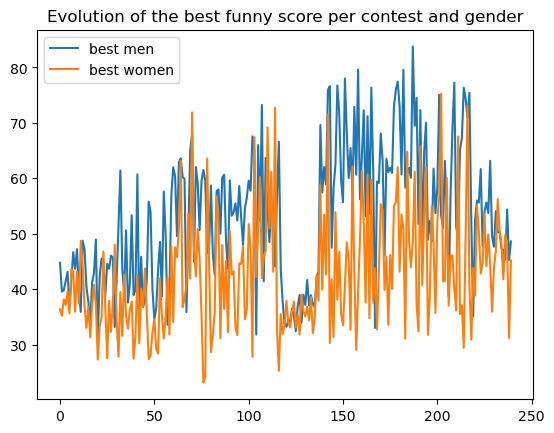

In [ ]:
plt.title("Evolution of the best funny score per contest and gender")
plt.plot(best_funny_m, label = 'best men')
plt.plot(best_funny_w, label = 'best women')
plt.xlabel("contest")
plt.ylabel("Score")
plt.legend()

Here we confirm the difference in mean, for some contests the best men related captions are much better in score than the women.

Let's plot the difference in score to make it more readable.

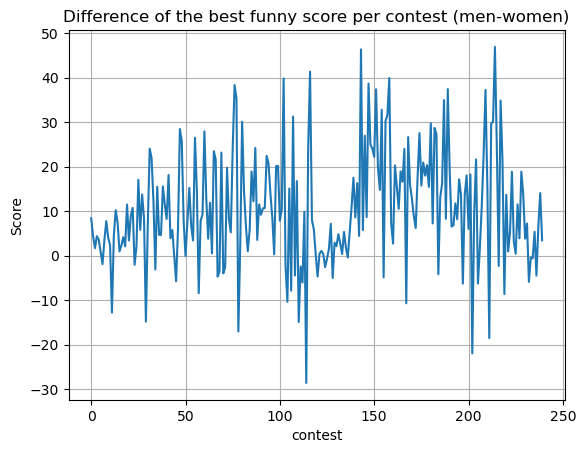

In [67]:
plt.title("Difference of the best funny score per contest (men-women)")
plt.plot(np.array(best_funny_m)-np.array(best_funny_w))
plt.xlabel("contest")
plt.ylabel("Score")
plt.grid()

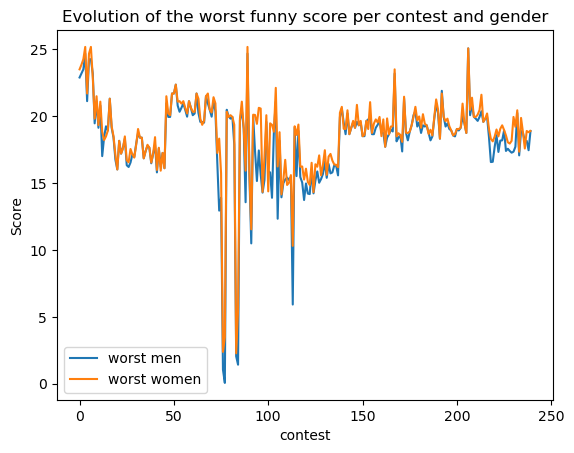

In [66]:
plt.title("Evolution of the worst funny score per contest and gender")
plt.plot(worst_funny_m, label = 'worst men')
plt.plot(worst_funny_w, label = 'worst women')
plt.xlabel("contest")
plt.ylabel("Score")
plt.legend()

The worst scores are almost the same over all contest ! So the worst captions are equally bad for each gender.

## Other codes

In [ ]:
list_id = dataC1[dataC1['gender_mention'] == 'both']['contest_id'].values

In [ ]:
i = 15
print(list_id[i])
plot_cartoon(list_id[i], root)
index = dataC[dataC['contest_id'] == list_id[i]].index[0]
dataA[index].caption.values[0]

582


'Yes, I see the train but I think we can beat it.'

### Sentiment Analysis

#### Over all contests

In [ ]:
ga = GenderAnalysis()

In [ ]:
# caption_female_df = pd.read_csv(r"src/data/all_caption_female_1.csv")
# caption_male_df = pd.read_csv(r"src/data/all_caption_male_1.csv")

In [ ]:
# male_caps   = caption_male_df['caption'].tolist()
# female_caps = caption_female_df['caption'].tolist()

In [ ]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions_1.pkl'
data_caption = ga.load_pickle(STORED_DATACAPTION_PKL_PATH)

In [ ]:
### --- MODELS ---
nlp = spacy.load('en_core_web_sm')
analyzer = SentimentIntensityAnalyzer()
### --------------

mean_sent_female = []
std_sent_female = []
mean_sent_male = []
std_sent_male = []
# to store the sentiment score associated with each caption
all_sentiment_female = []
all_sentiment_male = []

### --- Sentiment score ---
for contest in data_caption:

    male_caps   = contest[contest['gender_mention'] == 'male']['caption'].tolist()
    female_caps = contest[contest['gender_mention'] == 'female']['caption'].tolist()

    sent_female = []
    sent_male = []
    
    # #iterate through the sentences, get polarity scores
    for doc in nlp.pipe(female_caps):
        for sent in doc.sents:
            sent_female.append(analyzer.polarity_scores(sent.text)['compound'])
        
    for doc in nlp.pipe(male_caps):
        for sent in doc.sents:
            sent_male.append(analyzer.polarity_scores(sent.text)['compound'])

    mean_sent_male.append(np.mean(sent_male))
    std_sent_male.append(np.std(sent_male))
    mean_sent_female.append(np.mean(sent_female))
    std_sent_female.append(np.std(sent_female))

    all_sentiment_female.append(sent_female)
    all_sentiment_male.append(sent_male)

### ------------------------

In [ ]:
STORED_SENTIMENT_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\sentiment_analysis.pkl'
with open(STORED_SENTIMENT_PKL_PATH, "wb") as f:
    pickle.dump({"mean_sent_female": mean_sent_female, "mean_sent_male": mean_sent_male, "std_sent_female": std_sent_female, "std_sent_male": std_sent_male, "all_sentiment_female": all_sentiment_female, "all_sentiment_male": all_sentiment_male}, f)

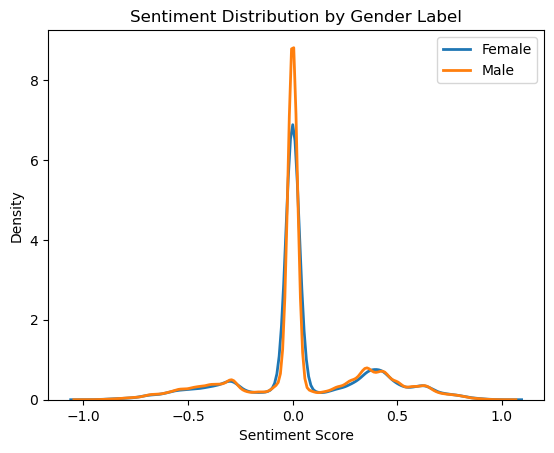

In [ ]:
### Visualisation of the sentiment distribution
list_all_sentiment_female = ga.flatten(all_sentiment_female)
list_all_sentiment_male = ga.flatten(all_sentiment_male)

sns.kdeplot(list_all_sentiment_female, fill=False, label = 'Female', linewidth=2)
sns.kdeplot(list_all_sentiment_male, fill=False, label= "Male", linewidth=2)

plt.title("Sentiment Distribution by Gender Label")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

As we can see, the distriubtion are quite similar... Over all the contests the sentiment of women and related captions are the same. I think that was expected, indeed we are really taking all of the captions into account, if this wasn't the case that would be concerning.

We need to dig deeper, let's focus on the sentiment associated with the topics we found earlier. We'll compute the sentiment related to each topic per gender, and we have the following graph.

### Per topic

In [ ]:
# ## Sentiment Analysis per Topic and per gender

# sia = SentimentIntensityAnalyzer()

# def compute_sentiment(text):
#     return sia.polarity_scores(text)["compound"]

# df_topics_female = pd.read_csv("src/data/topic_female.csv")
# df_topics_male = pd.read_csv("src/data/topic_male.csv")

# # Apply to each dataframe
# df_topics_male["sentiment"] = df_topics_male["caption"].apply(compute_sentiment)
# df_topics_female["sentiment"] = df_topics_female["caption"].apply(compute_sentiment)

# # Add gender label
# df_topics_male["gender_label"] = "male"
# df_topics_female["gender_label"] = "female"

# df = pd.concat([df_topics_male, df_topics_female], ignore_index=True)
# avg_sentiment = (
#     df.groupby(["aggregated_theme", "gender_label"])["sentiment"]
#       .mean()
#       .reset_index()
# )

# themes_male = set(df_topics_male["aggregated_theme"].dropna().unique())
# themes_female = set(df_topics_female["aggregated_theme"].dropna().unique())

# common_themes = themes_male.intersection(themes_female)
# df_common = df[df["aggregated_theme"].isin(common_themes)]

# df_common.to_csv(r'src/data/sentiment_common_topics.csv', index=False)  

In [ ]:
import plotly.graph_objects as go
def plot_average_sentiment_by_theme_plotly(
    df_common,
    title: str = "Average Sentiment by Theme (Common Themes Only)",
    xlabel: str = "Theme",
    ylabel: str = "Average Sentiment",
    pos_threshold: float = 0.05,
    neg_threshold: float = -0.05, 
    save: str = None
):
    """
    Plot mean sentiment per theme and gender with 95% CI.
    """

    # --- Aggregate: mean, std, count ---
    summary = (
        df_common
        .groupby(["aggregated_theme", "gender_label"])
        .agg(
            mean_sentiment=("sentiment", "mean"),
            std_sentiment=("sentiment", "std"),
            n=("sentiment", "count")
        )
        .reset_index()
    )

    # --- 95% confidence interval ---
    summary["ci"] = 1.96 * summary["std_sentiment"] / np.sqrt(summary["n"])

    # --- Build figure ---
    fig = go.Figure()

    for gender in summary["gender_label"].unique():
        df_g = summary[summary["gender_label"] == gender]

        fig.add_trace(
            go.Bar(
                x=df_g["aggregated_theme"],
                y=df_g["mean_sentiment"],
                name=gender,
                error_y=dict(
                    type="data",
                    array=df_g["ci"],
                    visible=True
                ),
                hovertemplate=(
                    "<b>Theme:</b> %{x}<br>"
                    f"<b>Gender:</b> {gender}<br>"
                    "<b>Mean sentiment:</b> %{y:.3f}<br>"
                    "<b>95% CI:</b> ±%{error_y.array:.3f}"
                    "<extra></extra>"
                )
            )
        )

    # --- Sentiment threshold lines ---
    fig.add_hline(
        y=pos_threshold,
        line_dash="dot",
        line_color="green"
    )

    fig.add_hline(
        y=neg_threshold,
        line_dash="dot",
        line_color="red"
    )

    # --- Neutral zone shading ---
    fig.add_hrect(
        y0=neg_threshold,
        y1=pos_threshold,
        fillcolor="gray",
        opacity=0.12,
        line_width=0
    )

    # --- Layout ---
    fig.update_layout(
        title=dict(text=title, x=0.5),
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        barmode="group",
        template="plotly_white",
        width=1300,
        height=600,
        legend_title="Gender",
        hovermode="closest"
    )

    fig.update_xaxes(tickangle=90)
    fig.update_yaxes(
        zeroline=True,
        zerolinecolor="black",
        showgrid=True,
        gridcolor="rgba(0,0,0,0.05)"
    )

    fig.show()


In [ ]:
df_common = pd.read_csv(r'src/data/sentiment_common_topics.csv')
# add ga.
plot_average_sentiment_by_theme_plotly(df_common, save = r"saved plots\avg_sentiment_theme.html")

As we can see, the difference is not striking. Most of the common topics are still mostly neutral. The sentiment for each gender are mostly close for each topic. The ones that stood out the most for me are Family Roles, History, Politics, Climate, Mariage and Fantasy & Mythology. Let's try and do some analysis on these topics.

#### Topic specific analysis

In [ ]:
df_common = pd.read_csv(r'src/data/sentiment_common_topics.csv')

In [ ]:
df_common.columns

Index(['Unnamed: 0', 'caption', 'topic', 'aggregated_theme', 'sentiment',
       'gender_label'],
      dtype='object')

In [ ]:
df_common_family = df_common[df_common['aggregated_theme'] == "Family roles"]
df_common_politics = df_common[df_common['aggregated_theme'] == "Politics"]
df_common_history = df_common[df_common['aggregated_theme'] == "History"]
df_common_climate = df_common[df_common['aggregated_theme'] == "Climate"]
df_common_fantasy = df_common[df_common['aggregated_theme'] == "Fantasy & mythology"]

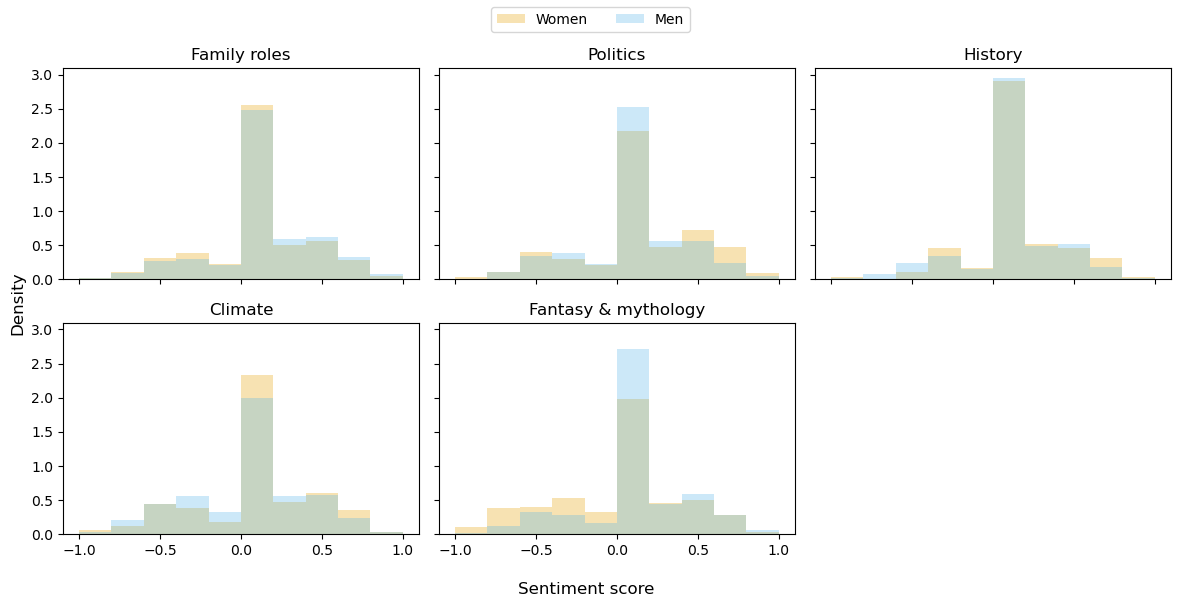

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

list_df = [
    df_common_family,
    df_common_politics,
    df_common_history,
    df_common_climate,
    df_common_fantasy
]

list_title = [
    "Family roles",
    "Politics",
    "History",
    "Climate",
    "Fantasy & mythology"
]

bins = np.linspace(-1, 1, 11)
color_female = "#E69F00"
color_male = "#56B4E9"

for idx, (df, title) in enumerate(zip(list_df, list_title)):
    row, col = divmod(idx, 3)

    female = df[df["gender_label"] == "female"]["sentiment"].values
    male = df[df["gender_label"] == "male"]["sentiment"].values

    ax[row, col].hist(
        female, bins=bins, density=True,
        alpha=0.3, label="Women", color=color_female
    )
    ax[row, col].hist(
        male, bins=bins, density=True,
        alpha=0.3, label="Men", color=color_male
    )

    ax[row, col].set_title(title)

# Turn off the unused subplot
ax[1, 2].axis("off")

# Figure-level labels and legend
fig.supxlabel("Sentiment score")
fig.supylabel("Density")
fig.legend(["Women", "Men"], loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Once more we see that the distribution are overlapping. But let's do some statistical testing just to be sure and make our analysis VERY scientific.

##### Statistical testing

Here the idea is to test wether the sentiment is different for each gender and topic.

In [ ]:
# nlp = spacy.load('en_core_web_sm')
# analyzer = SentimentIntensityAnalyzer()

# positive_sent_ = []
# negative_sent_ = []
# total_sent_ = []
# i = 0
# # #iterate through the sentences, get polarity scores, choose a value
# for doc in nlp.pipe(female_caps):
#     for sent in doc.sents:
#         positive_sent_.append(analyzer.polarity_scores(sent.text)['pos'])
#         negative_sent_.append(analyzer.polarity_scores(sent.text)['neg'])
#         total_sent_.append(analyzer.polarity_scores(sent.text)['compound']) 
#     i += 1

In [ ]:
# print(f"Women sentiment")
# print(f'Number of positive sentences: {sum(np.array(total_sent_)>=0.05)/len(total_sent_)}')
# print(f'Number of negative sentences:{sum(np.array(total_sent_)<=-0.05)/len(total_sent_)}')
# print(f'Number of neutral sentences: {sum(np.abs(np.array(total_sent_))<0.05)/len(total_sent_)}')

Women sentiment
Number of positive sentences: 0.27378097521982414
Number of negative sentences:0.17876069514758564
Number of neutral sentences: 0.5474583296325902


In [ ]:
# positive_sent = []
# negative_sent = []
# total_sent = []
# i = 0
# # #iterate through the sentences, get polarity scores, choose a value
# for doc in nlp.pipe(male_caps):
#     for sent in doc.sents:
#         positive_sent.append(analyzer.polarity_scores(sent.text)['pos'])
#         negative_sent.append(analyzer.polarity_scores(sent.text)['neg'])
#         total_sent.append(analyzer.polarity_scores(sent.text)['compound']) 
#     i += 1

In [ ]:
# print(f"Men sentiment")
# print('Ratio of positive sentences:',sum(np.array(total_sent)>=0.05)/len(total_sent))
# print('Ratio of negative sentences:',sum(np.array(total_sent)<=-0.05)/len(total_sent))
# print('Ration of neutral sentences:',sum(np.abs(np.array(total_sent))<0.05)/len(total_sent))

Men sentiment
Ratio of positive sentences: 0.28677679233856695
Ratio of negative sentences: 0.19187401525260656
Ration of neutral sentences: 0.5213491924088265


In [ ]:
def plot_topic(df_topics, gender):
    theme_counts = df_topics["aggregated_theme"].value_counts().sort_values(ascending=False)
    total_captions = theme_counts.sum()
    theme_percent = (theme_counts / total_captions) * 100

    circle_data = []

    for theme in theme_counts.index:
        theme_size = theme_counts[theme]

        circle_data.append(dict(
            id=theme,
            parent="",
            value=theme_size,
            percent=theme_percent[theme]
        ))

    df_circles = pd.DataFrame(circle_data)

    fig = px.treemap(
        df_circles,
        names="id",
        parents="parent",
        values="value",
        color="id",
        color_discrete_sequence=px.colors.qualitative.Set3,
        title=f"Themes in {gender} labeled captions",
        custom_data=["percent"]
    )

    fig.update_traces(root_color="lightgrey")

    fig.update_traces(
    hovertemplate="<b>%{label}</b><br>" +
                  "Count: %{value}<br>" +
                  "Percent: %{customdata[0]:.2f}%<extra></extra>"
    )

    fig.show()

    return fig

In [23]:
male_terms = [
            'guy', 'spokesman', 'chairman', "men's", 'men', 'him', "he's", 'his', 'boy',
            'boyfriend', 'boyfriends', 'boys', 'brother', 'brothers', 'dad', 'dads',
            'dude', 'father', 'fathers', 'fiance', 'gentleman', 'gentlemen', 'god',
            'grandfather', 'grandpa', 'grandson', 'groom', 'he', 'himself', 'husband',
            'husbands', 'king', 'male', 'man', 'mr', 'nephew', 'nephews', 'priest',
            'prince', 'son', 'sons', 'uncle', 'uncles', 'waiter', 'widower', 'widowers',
            'congressman',

            # --- Added universal & contextual male terms ---
            'bloke', 'chap', 'fella', 'gent', 'sir', 'lad', 'lads',
            'manliness', 'masculine', 'boyhood',
            'father-in-law', 'stepfather', 'stepson',
            'godfather', 'old man',
            'bachelor', 'groomsman',
            'kings',
            'monk', 'wizard',
            'policeman', 'fireman', 'salesman', 'businessman', 'workman',

            # --- Public figures ---
            "bush", "sanders",
            "einstein", "hitchcock", "bansky", "kanye", "obama","biden","trump","putin","zelenskyy",
            "macron","schwarzenegger","clooney","hanks","dicaprio",
            "pitt","depp","cruise","stallone","eastwood","gosling","carey","seinfeld","rock","chappelle",
            "sandler","springsteen","dylan","cobain","mars","drake","sheeran","mccartney","lennon",
            "jagger","bale","damon","affleck","reynolds","washington","freeman","jackson","smith","murphy",
            "reeves","keaton","downey","ruffalo","leno","colbert","stewart","oppenheimer","gates","musk"


            # --- 200 Most Popular American male names ---
            "james","robert","john","michael","david","william","richard","joseph","thomas","charles",
            "christopher","daniel","matthew","anthony","mark","donald","steven","paul","andrew","joshua",
            "kenneth","kevin","brian","george","edward","ronald","timothy","jason","jeffrey","ryan",
            "jacob","gary","nicholas","eric","jonathan","stephen","larry","justin","scott","brandon",
            "benjamin","samuel","gregory","alexander","frank","patrick","raymond","jack","dennis","jerry",
            "tyler","aaron","jose","adam","nathan","henry","douglas","zachary","peter","kyle",
            "walter","ethan","jeremy","harold","keith","christian","roger","noah","gerald","carl",
            "terry","sean","austin","arthur","lawrence","jesse","dylan","bryan","joe","jordan",
            "billy","bruce","albert","willie","gabriel","logan","alan","juan","wayne","roy",
            "ralph","randy","eugene","vincent","bobby","russell","louis","philip","johnny","riley",
            "victor","mason","dale","brett","caleb","curtis","phillip","nathaniel","rodney","cody",
            "joel","craig","tony","evan","shawn","wesley","alex","travis","chad","derrick",
            "stanley","leonard","connor","oscar","xavier","miguel","edwin","martin","emmanuel","jay",
            "clifford","herman","seth","edgar","mario","frederick","allen","tyrone","max","aiden",
            "colton","hector","jon","spencer","rick","clarence","malik","leo","dustin","maurice",
            "dominic","hayden","troy","gordon","marshall","abel","andre","lawson","reed","ramon",
            "lance","casey","terrence","francis","trevor","jared","marco","darren","eli","ben",
            "rafael","don","diego","romeo","ruben","clayton","carlos","kirk","brayden","ronnie",
            "felix","jimmy","asher","camden","harvey","brendan","tristan","dean","parker","francisco",
            "ivan","milo","ted"
        ]

In [21]:
dataA[0]['caption'][3901]

"This has 'Alice in Wonderland' beat by a mile."

In [15]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
example = data_caption[0]['caption'].values[0]
example

"i'm a congressman--obstruction is my job."

In [21]:
example = data_caption[0]['caption'].values[0]
doc = nlp(example)

In [24]:
tokens = [token.text for token in doc]
print(tokens)

['This', 'has', "'", 'Alice', 'in', 'Wonderland', "'", 'beat', 'by', 'a', 'mile', '.']


In [25]:
pos_tagged = [(token.text, token.pos_) for token in doc]
print(pos_tagged)

[('This', 'PRON'), ('has', 'VERB'), ("'", 'PUNCT'), ('Alice', 'PROPN'), ('in', 'ADP'), ('Wonderland', 'PROPN'), ("'", 'PUNCT'), ('beat', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('mile', 'NOUN'), ('.', 'PUNCT')]


In [26]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Alice PERSON
Wonderland GPE
a mile QUANTITY


In [ ]:
def extract_nouns(dataA):
    nlp = spacy.load("en_core_web_sm")
    nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

    for text in captions:
        doc = nlp(text)
        for token in doc:
            if token.pos_ in ["NOUN"]:  # common + proper nouns
                nouns[token.lemma_] += 1
    return nouns

def extract_proper_nouns(dataA):

    nlp = spacy.load("en_core_web_sm")
    proper_nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

        for text in captions:
            doc = nlp(text)
            for ent in doc.ents:
                if ent.label_ == 'PERSON':
                    proper_nouns[ent.text] += 1

    return proper_nouns

In [61]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

verbs_male = []
verbs_female = []
adjs_male = []
adjs_female = []

# Create two separated document: one with all the male and the other with all of the female captions
for contest in data_caption:
    # initialize lists that keep track of type of words
    verb_male = []
    verb_female = []
    adj_male = []
    adj_female = []


    # find in each caption that are labeled as male the verb and ajdectives
    male_captions = contest[contest['gender_mention'] == 'male'].caption.values
    for caption in male_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_male.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_male.append(token.text)


    # find in each caption that are labeled as female the verb and ajdectives
    female_captions = contest[contest['gender_mention'] == 'female'].caption.values
    for caption in female_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_female.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_female.append(token.text)

    
    verbs_male.append(verb_male)
    verbs_female.append(verb_female)
    adjs_male.append(adj_male)
    adjs_female.append(adj_female)
    break

In [ ]:
## LDA Model -> UNSTABLE    

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import re

# Download NLTK stopwords
# nltk.download('stopwords')
stop_words = stopwords.words('english')

# Load data
data = pd.read_csv('all_caption_female.csv')

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails
    text = re.sub('\'', '', text)  # Remove apostrophes
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    return text

# Tokenize and remove stopwords
def tokenize(text):
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

def lemmatize(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

data['cleaned_text'] = data['caption'].apply(preprocess_text) 
data['tokens'] = data['cleaned_text'].apply(tokenize)

# Lemmatization using spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data['lemmas'] = data['tokens'].apply(lemmatize)

# Create dictionary and corpus
id2word = corpora.Dictionary(data['lemmas'])
texts = data['lemmas']
corpus = [id2word.doc2bow(text) for text in texts]

Number of topics: 6.0
Number of topics: 7.0
Number of topics: 8.0
Number of topics: 9.0
Number of topics: 10.0
Number of topics: 11.0
Number of topics: 12.0
Number of topics: 13.0
Number of topics: 14.0
Number of topics: 15.0
Number of topics: 16.0
Number of topics: 17.0
Number of topics: 18.0
Number of topics: 19.0
Number of topics: 20.0


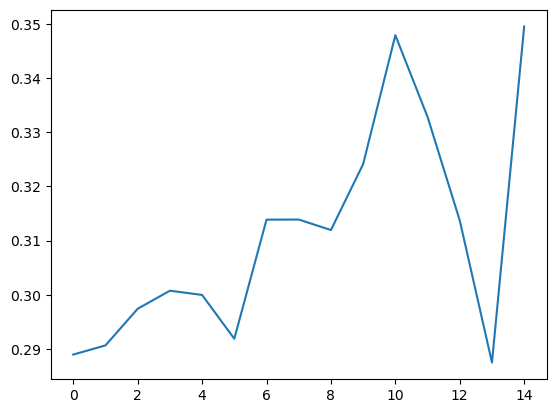

In [ ]:
num_topics_list = np.linspace(6, 20, 15)

coherence_score = []

for i in num_topics_list:
    print(f"Number of topics: {i}")
    # Build LDA model, NUMBER OF TOPICS: pick the one that has the highest coherence score.
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=i, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    # Print the topics
    # topics = lda_model.print_topics(num_words=5)
    # for topic in topics:
    #     print(topic)

    # Compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemmas'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

plt.plot(coherence_score)

In [59]:
# ## From the exercices

# analyzer = SentimentIntensityAnalyzer()
# vs = analyzer.polarity_scores(example)

# print(example, '\n')
# print('Negative sentiment:',vs['neg'])
# print('Neutral sentiment:',vs['neu'])
# print('Positive sentiment:',vs['pos'])
# print('Compound sentiment:',vs['compound'])

# nlp = spacy.load('en_core_web_sm')
# doc = nlp(books[3])

# positive_sent = []
# #iterate through the sentences, get polarity scores, choose a value
# [positive_sent.append(analyzer.polarity_scores(sent.text)['pos']) for sent in doc.sents]
# plt.hist(positive_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Positive sentiment')
# plt.ylabel('Number of sentences')

# negative_sent = []
# [negative_sent.append(analyzer.polarity_scores(sent.text)['neg']) for sent in doc.sents]
# plt.hist(negative_sent,bins=15)
# plt.xlim([0,1])
# plt.ylim([0,8000])
# plt.xlabel('Negative sentiment')
# plt.ylabel('Number of sentences')

# total_sent = []
# [total_sent.append(analyzer.polarity_scores(sent.text)['compound']) for sent in doc.sents]
# plt.hist(total_sent,bins = 15)
# plt.xlim([-1,1])
# plt.ylim([0,8000])
# plt.xlabel('Compound sentiment')
# plt.ylabel('Number of sentences')

# sents = [analyzer.polarity_scores(sent.text)['compound'] for sent in doc.sents]
# print('Number of positive sentences:',sum(np.array(sents)>=0.05))
# print('Number of negative sentences:',sum(np.array(sents)<=-0.05))
# print('Number of neutral sentences:',sum(np.abs(np.array(sents))<0.05))